In [14]:
import yaml
import os
from towbintools.foundation import file_handling as file_handling
import pandas as pd
from pipeline_scripts.utils import (
    get_experiment_pads,
    get_and_create_folders,
    add_dir_to_experiment_filemap,
    create_temp_folders,
    backup_file,
    get_experiment_time_from_filemap_parallel,
    merge_and_save_csv,
    rename_merge_and_save_csv,
)
import numpy as np
from pipeline_scripts.run_functions import (
    run_segmentation,
    run_straightening,
    run_compute_volume,
    run_classification,
    run_detect_molts,
    run_fluorescence_quantification,
    run_custom,
)
import argparse
from pipeline_scripts.building_blocks import build_config_of_building_blocks
import matplotlib.pyplot as plt

from towbintools.data_analysis import compute_growth_rate_per_larval_stage, correct_series_with_classification, filter_series_with_classification, compute_larval_stage_duration

In [15]:
filemap_path = "/mnt/towbin.data/shared/kstojanovski/20240625_Orca_10x_yap-1aid-raga-1aid_wBT186-437-438-439_25C_20240625_154359_670/analysis/report/analysis_filemap_annotated.csv"
experiment_filemap = pd.read_csv(filemap_path)
experiment_filemap.head()

,Time,Point,raw,ExperimentTime,analysis/ch2_seg,analysis/ch1_seg,analysis/ch1_ch2_raw_str,analysis/ch1_seg_str,analysis/ch2_seg_str,ch1_seg_str_volume,...,ch2_seg_str_area_at_M1,ch2_seg_str_area_at_M2,ch2_seg_str_area_at_M3,ch2_seg_str_area_at_M4,VolumeAtM1,VolumeAtM3,VolumeAtM2,VolumeAtHatch,VolumeAtM4,None
0,0,0,/mnt/towbin.data/shared/kstojanovski/20240625_...,0.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,1848.247358,...,5445.565095,10902.034779,19614.243592,36045.450594,NaN,NaN,190111.361337,NaN,NaN,NaN
1,1,0,/mnt/towbin.data/shared/kstojanovski/20240625_...,599.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,1720.558896,...,5445.565095,10902.034779,19614.243592,36045.450594,NaN,NaN,190111.361337,NaN,NaN,NaN
2,2,0,/mnt/towbin.data/shared/kstojanovski/20240625_...,1199.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,1600.419582,...,5445.565095,10902.034779,19614.243592,36045.450594,NaN,NaN,190111.361337,NaN,NaN,NaN
3,3,0,/mnt/towbin.data/shared/kstojanovski/20240625_...,1800.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,1706.539048,...,5445.565095,10902.034779,19614.243592,36045.450594,NaN,NaN,190111.361337,NaN,NaN,NaN
4,4,0,/mnt/towbin.data/shared/kstojanovski/20240625_...,2400.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,1036.174619,...,5445.565095,10902.034779,19614.243592,36045.450594,NaN,NaN,190111.361337,NaN,NaN,NaN


In [16]:
config_path = './config.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
    file.close()

def build_conditions(config):
    conditions = []
    condition_id = 0

    for condition in config["conditions"]:
        condition = {key: [val] if not isinstance(val, list) else val for key, val in condition.items()}

        lengths = set(len(val) for val in condition.values())
        if len(lengths) > 2 or (len(lengths) == 2 and 1 not in lengths):
            raise ValueError("All lists in the condition must have the same length or be of length 1.")

        max_length = max(lengths)
        for i in range(max_length):
            condition_dict = {
                key: val[0] if len(val) == 1 else val[i]
                for key, val in condition.items()
            }
            condition_dict["condition_id"] = condition_id
            conditions.append(condition_dict)
            condition_id += 1

    return conditions
    
conditions = build_conditions(config)
conditions

[{'auxin_concentration_um': 0,
  'strain': 'wBT186',
  'point_range': [0, 26],
  'condition_id': 0},
 {'auxin_concentration_um': 0,
  'strain': 'wBT437',
  'point_range': [27, 54],
  'condition_id': 1},
 {'auxin_concentration_um': 0,
  'strain': 'wBT438',
  'point_range': [55, 86],
  'condition_id': 2},
 {'auxin_concentration_um': 0,
  'strain': 'wBT439',
  'point_range': [87, 120],
  'condition_id': 3},
 {'auxin_concentration_um': 10,
  'strain': 'wBT186',
  'point_range': [121, 147],
  'condition_id': 4},
 {'auxin_concentration_um': 10,
  'strain': 'wBT437',
  'point_range': [148, 176],
  'condition_id': 5},
 {'auxin_concentration_um': 10,
  'strain': 'wBT438',
  'point_range': [177, 204],
  'condition_id': 6},
 {'auxin_concentration_um': 10,
  'strain': 'wBT439',
  'point_range': [205, 232],
  'condition_id': 7},
 {'auxin_concentration_um': 50,
  'strain': 'wBT186',
  'point_range': [233, 250],
  'condition_id': 8},
 {'auxin_concentration_um': 50,
  'strain': 'wBT437',
  'point_rang

In [17]:
experiment_filemap.columns

Index(['Time', 'Point', 'raw', 'ExperimentTime', 'analysis/ch2_seg',
       'analysis/ch1_seg', 'analysis/ch1_ch2_raw_str', 'analysis/ch1_seg_str',
       'analysis/ch2_seg_str', 'ch1_seg_str_volume', 'ch1_seg_str_length',
       'ch1_seg_str_area', 'ch2_seg_str_volume', 'ch2_seg_str_length',
       'ch2_seg_str_area', 'ch2_seg_str_worm_type', 'HatchTime',
       'ch2_seg_str_volume_at_HatchTime', 'M1', 'ch2_seg_str_volume_at_M1',
       'M2', 'ch2_seg_str_volume_at_M2', 'M3', 'ch2_seg_str_volume_at_M3',
       'M4', 'ch2_seg_str_volume_at_M4', 'ch1_seg_str_volume_at_HatchTime',
       'ch1_seg_str_volume_at_M1', 'ch1_seg_str_volume_at_M2',
       'ch1_seg_str_volume_at_M3', 'ch1_seg_str_volume_at_M4',
       'ch1_seg_str_length_at_HatchTime', 'ch1_seg_str_length_at_M1',
       'ch1_seg_str_length_at_M2', 'ch1_seg_str_length_at_M3',
       'ch1_seg_str_length_at_M4', 'ch2_seg_str_length_at_HatchTime',
       'ch2_seg_str_length_at_M1', 'ch2_seg_str_length_at_M2',
       'ch2_seg_str_le

In [18]:
def add_conditions_to_filemap(experiment_filemap, conditions, config):
    for condition in conditions:
        if "point_range" in condition.keys():
            point_range = condition["point_range"]
            # Get all the rows that are in the point range
            condition_rows = experiment_filemap[experiment_filemap["Point"].between(point_range[0], point_range[1])]
            # Remove the point range from the condition
            conditions_to_add = {key: val for key, val in condition.items() if key != "point_range"}
            for key, val in conditions_to_add.items():
                # Directly fill the rows with the value for the new or existing column
                experiment_filemap.loc[condition_rows.index, key] = val
    return experiment_filemap

experiment_filemap = add_conditions_to_filemap(experiment_filemap, conditions, config)
experiment_filemap.columns

Index(['Time', 'Point', 'raw', 'ExperimentTime', 'analysis/ch2_seg',
       'analysis/ch1_seg', 'analysis/ch1_ch2_raw_str', 'analysis/ch1_seg_str',
       'analysis/ch2_seg_str', 'ch1_seg_str_volume', 'ch1_seg_str_length',
       'ch1_seg_str_area', 'ch2_seg_str_volume', 'ch2_seg_str_length',
       'ch2_seg_str_area', 'ch2_seg_str_worm_type', 'HatchTime',
       'ch2_seg_str_volume_at_HatchTime', 'M1', 'ch2_seg_str_volume_at_M1',
       'M2', 'ch2_seg_str_volume_at_M2', 'M3', 'ch2_seg_str_volume_at_M3',
       'M4', 'ch2_seg_str_volume_at_M4', 'ch1_seg_str_volume_at_HatchTime',
       'ch1_seg_str_volume_at_M1', 'ch1_seg_str_volume_at_M2',
       'ch1_seg_str_volume_at_M3', 'ch1_seg_str_volume_at_M4',
       'ch1_seg_str_length_at_HatchTime', 'ch1_seg_str_length_at_M1',
       'ch1_seg_str_length_at_M2', 'ch1_seg_str_length_at_M3',
       'ch1_seg_str_length_at_M4', 'ch2_seg_str_length_at_HatchTime',
       'ch2_seg_str_length_at_M1', 'ch2_seg_str_length_at_M2',
       'ch2_seg_str_le

In [19]:
experiment_filemap["condition_id"].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [20]:
point_to_test = 100
point_filemap = experiment_filemap[experiment_filemap["Point"] == point_to_test]
point_filemap

# select the first value of the columns HatchTime, M1, M2, M3, M4 and convert them to a dictionary
point_ecdysis = point_filemap[["HatchTime", "M1", "M2", "M3", "M4"]].iloc[0].to_dict()
point_ecdysis_experiment_time = {'HatchTime' : point_filemap[point_filemap['Time'] == point_ecdysis['HatchTime']]['ExperimentTime'].iloc[0], 'M1' : point_filemap[point_filemap['Time'] == point_ecdysis['M1']]['ExperimentTime'].iloc[0], 'M2' : point_filemap[point_filemap['Time'] == point_ecdysis['M2']]['ExperimentTime'].iloc[0], 'M3' : point_filemap[point_filemap['Time'] == point_ecdysis['M3']]['ExperimentTime'].iloc[0], 'M4' : point_filemap[point_filemap['Time'] == point_ecdysis['M4']]['ExperimentTime'].iloc[0]}
point_ecdysis_experiment_time

# growth_rate_per_larval_stage = compute_growth_rate_per_larval_stage()

{'HatchTime': 7798.0,
 'M1': 59397.0,
 'M2': 91195.0,
 'M3': 121196.0,
 'M4': 159595.0}

In [21]:
for point in experiment_filemap["Point"].unique():
    point_filemap = experiment_filemap[experiment_filemap["Point"] == point]
    point_ecdysis = point_filemap[["HatchTime", "M1", "M2", "M3", "M4"]].iloc[0].to_dict()
    # point_ecdysis_experiment_time = {'HatchTime' : point_filemap[point_filemap['Time'] == point_ecdysis['HatchTime']]['ExperimentTime'].iloc[0], 'M1' : point_filemap[point_filemap['Time'] == point_ecdysis['M1']]['ExperimentTime'].iloc[0], 'M2' : point_filemap[point_filemap['Time'] == point_ecdysis['M2']]['ExperimentTime'].iloc[0], 'M3' : point_filemap[point_filemap['Time'] == point_ecdysis['M3']]['ExperimentTime'].iloc[0], 'M4' : point_filemap[point_filemap['Time'] == point_ecdysis['M4']]['ExperimentTime'].iloc[0]}
    point_ecdysis_experiment_time = {}
    for larval_stage, time_index in point_ecdysis.items():
        if not np.isnan(time_index):
            point_ecdysis_experiment_time[larval_stage] = point_filemap[point_filemap['Time'] == time_index]['ExperimentTime'].iloc[0]
        else:   
            point_ecdysis_experiment_time[larval_stage] = np.nan

    experiment_filemap.loc[point_filemap.index, 'HatchTimeExperimentTime'] = point_ecdysis_experiment_time['HatchTime']
    experiment_filemap.loc[point_filemap.index, 'M1ExperimentTime'] = point_ecdysis_experiment_time['M1']
    experiment_filemap.loc[point_filemap.index, 'M2ExperimentTime'] = point_ecdysis_experiment_time['M2']
    experiment_filemap.loc[point_filemap.index, 'M3ExperimentTime'] = point_ecdysis_experiment_time['M3']
    experiment_filemap.loc[point_filemap.index, 'M4ExperimentTime'] = point_ecdysis_experiment_time['M4']

    larval_stage_durations = compute_larval_stage_duration(point_ecdysis)

    experiment_filemap.loc[point_filemap.index, 'L1Duration'] = larval_stage_durations['L1']
    experiment_filemap.loc[point_filemap.index, 'L2Duration'] = larval_stage_durations['L2']
    experiment_filemap.loc[point_filemap.index, 'L3Duration'] = larval_stage_durations['L3']
    experiment_filemap.loc[point_filemap.index, 'L4Duration'] = larval_stage_durations['L4']
    
    larval_stage_durations_experiment_time = compute_larval_stage_duration(point_ecdysis_experiment_time)

    experiment_filemap.loc[point_filemap.index, 'L1DurationExperimentTime'] = larval_stage_durations_experiment_time['L1']
    experiment_filemap.loc[point_filemap.index, 'L2DurationExperimentTime'] = larval_stage_durations_experiment_time['L2']
    experiment_filemap.loc[point_filemap.index, 'L3DurationExperimentTime'] = larval_stage_durations_experiment_time['L3']
    experiment_filemap.loc[point_filemap.index, 'L4DurationExperimentTime'] = larval_stage_durations_experiment_time['L4']

experiment_filemap.head()

,Time,Point,raw,ExperimentTime,analysis/ch2_seg,analysis/ch1_seg,analysis/ch1_ch2_raw_str,analysis/ch1_seg_str,analysis/ch2_seg_str,ch1_seg_str_volume,...,M3ExperimentTime,M4ExperimentTime,L1Duration,L2Duration,L3Duration,L4Duration,L1DurationExperimentTime,L2DurationExperimentTime,L3DurationExperimentTime,L4DurationExperimentTime
0,0,0,/mnt/towbin.data/shared/kstojanovski/20240625_...,0.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,1848.247358,...,119999.0,157199.0,88.0,64.0,47.0,62.0,52800.0,38401.0,28199.0,37200.0
1,1,0,/mnt/towbin.data/shared/kstojanovski/20240625_...,599.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,1720.558896,...,119999.0,157199.0,88.0,64.0,47.0,62.0,52800.0,38401.0,28199.0,37200.0
2,2,0,/mnt/towbin.data/shared/kstojanovski/20240625_...,1199.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,1600.419582,...,119999.0,157199.0,88.0,64.0,47.0,62.0,52800.0,38401.0,28199.0,37200.0
3,3,0,/mnt/towbin.data/shared/kstojanovski/20240625_...,1800.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,1706.539048,...,119999.0,157199.0,88.0,64.0,47.0,62.0,52800.0,38401.0,28199.0,37200.0
4,4,0,/mnt/towbin.data/shared/kstojanovski/20240625_...,2400.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,1036.174619,...,119999.0,157199.0,88.0,64.0,47.0,62.0,52800.0,38401.0,28199.0,37200.0


In [22]:
def compute_development_progression(time, ecdysis, larval_stage_durations):
    # if the keys of the ecdysis dictionary are not HatchTime, M1, M2, M3, M4, but the dictionary has the right number of keys, rename the keys
    if not all(key in ecdysis for key in ['HatchTime', 'M1', 'M2', 'M3', 'M4']):
        if len(ecdysis) == 5:
            keys = list(ecdysis.keys())
            ecdysis = {'HatchTime': ecdysis[keys[0]], 'M1': ecdysis[keys[1]], 'M2': ecdysis[keys[2]], 'M3': ecdysis[keys[3]], 'M4': ecdysis[keys[4]]}
        else:
            raise ValueError("The ecdysis dictionary must have 5 keys corresponding to the time of each molt.")

    # if the keys of the larval_stage_durations dictionary are not L1, L2, L3, L4, but the dictionary has the right number of keys, rename the keys
    if not all(key in larval_stage_durations for key in ['L1', 'L2', 'L3', 'L4']):
        if len(larval_stage_durations) == 4:
            keys = list(larval_stage_durations.keys())
            larval_stage_durations = {'L1': larval_stage_durations[keys[0]], 'L2': larval_stage_durations[keys[1]], 'L3': larval_stage_durations[keys[2]], 'L4': larval_stage_durations[keys[3]]}
        else:
            raise ValueError("The larval_stage_durations dictionary must have 4 keys corresponding to the duration of earch larval stage.")
    
    # create an array of the same length as the time array and fill it with nans
    progression = np.full_like(time, np.nan)
    
    for i, t in enumerate(time):
        if not np.isnan(ecdysis['HatchTime']) and t < ecdysis['HatchTime']:
            progression[i] = 0.0
        elif not np.isnan(ecdysis['HatchTime']) and not np.isnan(ecdysis['M1']) and t <= ecdysis['M1']:
            progression[i] = (t - ecdysis['HatchTime']) / larval_stage_durations['L1'] * 100
        elif not np.isnan(ecdysis['M1']) and not np.isnan(ecdysis['M2']) and t <= ecdysis['M2'] and t > ecdysis['M1']:
            progression[i] = 100 + (t - ecdysis['M1']) / larval_stage_durations['L2'] * 100
        elif not np.isnan(ecdysis['M2']) and not np.isnan(ecdysis['M3']) and t <= ecdysis['M3'] and t > ecdysis['M2']:
            progression[i] = 200 + (t - ecdysis['M2']) / larval_stage_durations['L3'] * 100
        elif not np.isnan(ecdysis['M3']) and not np.isnan(ecdysis['M4']) and t <= ecdysis['M4'] and t > ecdysis['M3']:
            progression[i] = 300 + (t - ecdysis['M3']) / larval_stage_durations['L4'] * 100
        elif not np.isnan(ecdysis['M4']) and t > ecdysis['M4']:
            progression[i] = 401
        else:
            progression[i] = np.nan

    return progression

def development_progression_to_larval_stage(development_progression):
    larval_stage = np.ndarray(development_progression.shape, dtype='object')
    larval_stage[(development_progression > 0) & (development_progression < 100)] = 1
    larval_stage[(development_progression >= 100) & (development_progression < 200)] = 2
    larval_stage[(development_progression >= 200) & (development_progression < 300)] = 3
    larval_stage[(development_progression >= 300) & (development_progression < 400)] = 4
    larval_stage[development_progression >= 400] = 5
    return larval_stage

In [23]:
for point in experiment_filemap['Point'].unique():
    point_filemap = experiment_filemap[experiment_filemap['Point'] == point]
    point_ecdysis_experiment_time = point_filemap[['HatchTimeExperimentTime', 'M1ExperimentTime', 'M2ExperimentTime', 'M3ExperimentTime', 'M4ExperimentTime']].iloc[0].to_dict()
    larval_stage_durations_experiment_time = point_filemap[['L1DurationExperimentTime', 'L2DurationExperimentTime', 'L3DurationExperimentTime', 'L4DurationExperimentTime']].iloc[0].to_dict()
    time = point_filemap['ExperimentTime']
    progression = compute_development_progression(time, point_ecdysis_experiment_time, larval_stage_durations_experiment_time)
    experiment_filemap.loc[point_filemap.index, 'DevelopmentProgression'] = progression
    larval_stage = development_progression_to_larval_stage(progression)
    experiment_filemap.loc[point_filemap.index, 'LarvalStage'] = larval_stage

experiment_filemap[experiment_filemap['Point'] == 243]

,Time,Point,raw,ExperimentTime,analysis/ch2_seg,analysis/ch1_seg,analysis/ch1_ch2_raw_str,analysis/ch1_seg_str,analysis/ch2_seg_str,ch1_seg_str_volume,...,L1Duration,L2Duration,L3Duration,L4Duration,L1DurationExperimentTime,L2DurationExperimentTime,L3DurationExperimentTime,L4DurationExperimentTime,DevelopmentProgression,LarvalStage
99387,0,243,/mnt/towbin.data/shared/kstojanovski/20240625_...,0.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,2895.422166,...,NaN,82.0,55.0,63.0,NaN,49198.0,32998.0,37803.0,NaN,None
99388,1,243,/mnt/towbin.data/shared/kstojanovski/20240625_...,600.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,2770.106293,...,NaN,82.0,55.0,63.0,NaN,49198.0,32998.0,37803.0,NaN,None
99389,2,243,/mnt/towbin.data/shared/kstojanovski/20240625_...,1198.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,2880.323868,...,NaN,82.0,55.0,63.0,NaN,49198.0,32998.0,37803.0,NaN,None
99390,3,243,/mnt/towbin.data/shared/kstojanovski/20240625_...,1801.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,2904.481144,...,NaN,82.0,55.0,63.0,NaN,49198.0,32998.0,37803.0,NaN,None
99391,4,243,/mnt/towbin.data/shared/kstojanovski/20240625_...,2400.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,2938.775850,...,NaN,82.0,55.0,63.0,NaN,49198.0,32998.0,37803.0,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99791,404,243,/mnt/towbin.data/shared/kstojanovski/20240625_...,242398.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,20008.695815,...,NaN,82.0,55.0,63.0,NaN,49198.0,32998.0,37803.0,401.0,5
99792,405,243,/mnt/towbin.data/shared/kstojanovski/20240625_...,242998.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,18970.364296,...,NaN,82.0,55.0,63.0,NaN,49198.0,32998.0,37803.0,401.0,5
99793,406,243,/mnt/towbin.data/shared/kstojanovski/20240625_...,243599.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,20941.554938,...,NaN,82.0,55.0,63.0,NaN,49198.0,32998.0,37803.0,401.0,5
99794,407,243,/mnt/towbin.data/shared/kstojanovski/20240625_...,244199.0,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,/mnt/towbin.data/shared/kstojanovski/20240625_...,18740.223098,...,NaN,82.0,55.0,63.0,NaN,49198.0,32998.0,37803.0,401.0,5


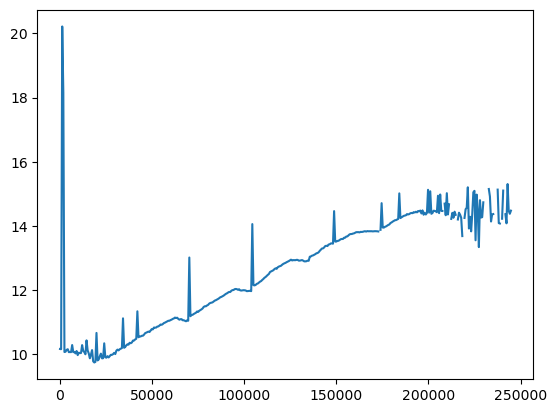

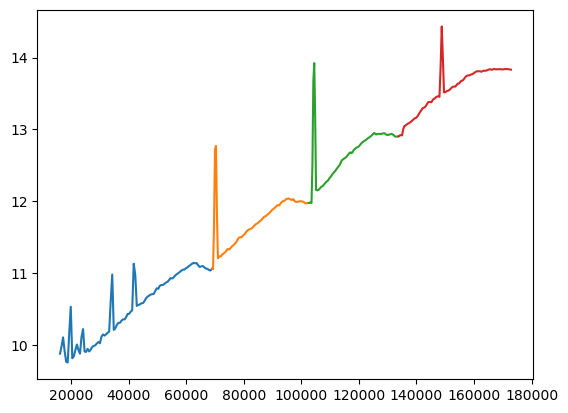

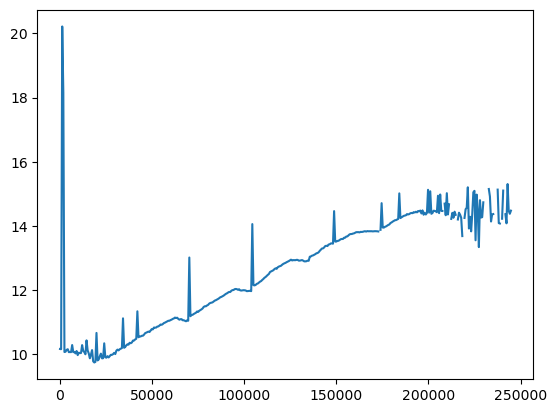

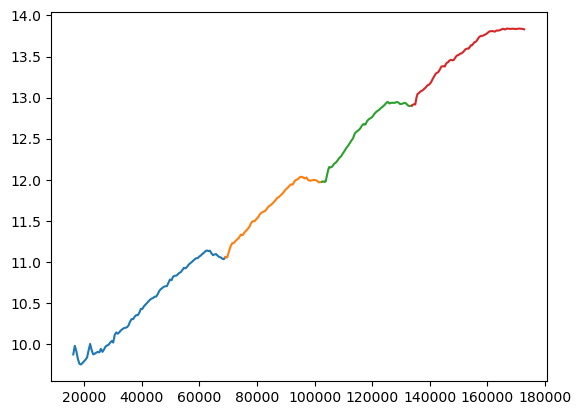

In [24]:
# For many things we want the worms development to have the same number of points, so we interpolate the data
from scipy import interpolate
interpolated_experiment_filemap = experiment_filemap['Point']

# # code a function to get ecdysis as a list !!!!
def get_ecdysis_as_array(ecdysis):
    ecdysis_list = []
    for key in ['HatchTime', 'M1', 'M2', 'M3', 'M4']:
        ecdysis_list.append(ecdysis[key])
    return np.array(ecdysis_list)

def interpolate_larval_stage(time, series, ecdysis, larval_stage, n_points = 100):
    if larval_stage < 1 or larval_stage > 4:
        raise ValueError("The larval stage must be between 1 and 4.")
    
    ecdysis_array = get_ecdysis_as_array(ecdysis)
    
    previous_ecdys = ecdysis_array[larval_stage-1]
    ecdys = ecdysis_array[larval_stage]

    # check that the molts are correct
    if (np.isnan(previous_ecdys) or np.isnan(ecdys)) or previous_ecdys > ecdys:
        return np.full(n_points, np.nan), np.full(n_points, np.nan)
    
    # convert ecdysis times to int to get the index
    previous_ecdys = int(previous_ecdys)
    ecdys = int(ecdys)

    interpolated_time = np.linspace(time[previous_ecdys], time[ecdys], n_points)
    interpolated_series = interpolate.interp1d(time, series, kind='linear')(interpolated_time)

    return interpolated_time, interpolated_series
    
def interpolate_entire_development(time, series, ecdysis, n_points = 100):
    interpolated_time = np.full((4, n_points), np.nan)
    interpolated_series = np.full((4, n_points), np.nan)
    for larval_stage in range(1, 5):
        interpolated_time_stage, interpolated_series_stage = interpolate_larval_stage(time, series, ecdysis, larval_stage, n_points)
        
        interpolated_time[larval_stage - 1, :] = interpolated_time_stage
        interpolated_series[larval_stage - 1, :] = interpolated_series_stage

    return interpolated_time, interpolated_series

def interpolate_entire_development_classified(time, series, ecdysis, worm_type, n_points = 100):
    time = filter_series_with_classification(time, worm_type)
    series = filter_series_with_classification(series, worm_type)
    
    return interpolate_entire_development(time, series, ecdysis, n_points)


point_filemap = experiment_filemap[experiment_filemap['Point'] == 11]
point_ecdysis_experiment_time = point_filemap[['HatchTime', 'M1', 'M2', 'M3', 'M4']].iloc[0]

interpolated_time, interpolated_series = interpolate_entire_development(point_filemap['ExperimentTime'].values, point_filemap['ch2_seg_str_volume'].values, point_ecdysis_experiment_time)

plt.plot(point_filemap['ExperimentTime'], np.log(point_filemap['ch2_seg_str_volume']))
plt.show()

for l in range(4):
    plt.plot(interpolated_time[l], np.log(interpolated_series[l]))

plt.show()

interpolated_time, interpolated_series = interpolate_entire_development_classified(point_filemap['ExperimentTime'].values, point_filemap['ch2_seg_str_volume'].values, point_ecdysis_experiment_time, point_filemap['ch2_seg_str_worm_type'].values)

plt.plot(point_filemap['ExperimentTime'], np.log(point_filemap['ch2_seg_str_volume']))
plt.show()

for l in range(4):
    plt.plot(interpolated_time[l], np.log(interpolated_series[l]))

plt.show()

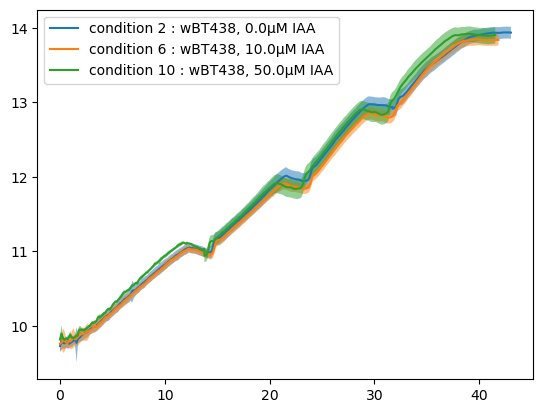

In [25]:
def rescale_and_aggregate(dataframe, time_column, column, worm_type_column, points=None, aggregation='mean', n_points=100):

    if points is not None:
        dataframe = dataframe[dataframe['Point'].isin(points)]
    
    aggregation_function = np.nanmean if aggregation == 'mean' else np.nanmedian
    
    # Interpolate the time and the series

    all_points_interpolated_time = []
    all_points_interpolated_series = []
    all_points_larval_stage_durations = np.empty((0, 4))

    for point in dataframe['Point'].unique():
        point_df = dataframe[dataframe['Point'] == point]
        point_ecdysis_indices = point_df[['HatchTime', 'M1', 'M2', 'M3', 'M4']].iloc[0]
        if time_column == 'ExperimentTime':
            larval_stage_durations = point_df[['L1DurationExperimentTime', 'L2DurationExperimentTime', 'L3DurationExperimentTime', 'L4DurationExperimentTime']].iloc[0]
        else:
            larval_stage_durations = point_df[['L1Duration', 'L2Duration', 'L3Duration', 'L4Duration']].iloc[0]

        all_points_larval_stage_durations = np.vstack((all_points_larval_stage_durations, larval_stage_durations))
        
        time = point_df[time_column].values
        series = point_df[column].values
        worm_type = point_df[worm_type_column].values

        interpolated_time, interpolated_series = interpolate_entire_development_classified(time, series, point_ecdysis_indices, worm_type, n_points = n_points)

        all_points_interpolated_time.append(interpolated_time)
        all_points_interpolated_series.append(interpolated_series)
    
    all_points_interpolated_time = np.array(all_points_interpolated_time)
    all_points_interpolated_series = np.array(all_points_interpolated_series)

    aggregated_series = np.full((4, n_points), np.nan)
    std_series = np.full((4, n_points), np.nan)
    ste_series = np.full((4, n_points), np.nan)
    rescaled_time = np.full((4, n_points), np.nan)

    aggregated_larval_stage_durations = aggregation_function(all_points_larval_stage_durations, axis=0)
    
    for i in range(4):
        aggregated_series[i, :] = aggregation_function(all_points_interpolated_series[:, i, :], axis=0)
        std_series[i, :] = np.nanstd(all_points_interpolated_series[:, i, :], axis=0)
        ste_series[i, :] = np.nanstd(all_points_interpolated_series[:, i, :], axis=0) / np.sqrt(np.sum(np.isfinite(all_points_interpolated_series[:, i, :])))

        beginning = np.nansum(aggregated_larval_stage_durations[:i+1]) - aggregated_larval_stage_durations[i]
        end = np.nansum(aggregated_larval_stage_durations[:i+1])
        rescaled_time[i, :] = np.linspace(beginning, end, n_points)

    # flatten the arrays
    aggregated_series = aggregated_series.flatten()
    std_series = std_series.flatten()
    ste_series = ste_series.flatten()
    rescaled_time = rescaled_time.flatten()

    return rescaled_time, aggregated_series, std_series, ste_series

# for cond in [0, 4, 8]:
# for cond in [1, 5, 9]:
for cond in [2, 6, 10]:
# for cond in [3, 7, 11]:
# for cond in experiment_filemap['condition_id'].unique():
    df_condition = experiment_filemap[experiment_filemap['condition_id'] == cond]
    rescaled_time, aggregated_series, std_series, ste_series =rescale_and_aggregate(df_condition, 'ExperimentTime', 'ch2_seg_str_volume', 'ch2_seg_str_worm_type', aggregation='mean')

    plt.plot(rescaled_time/3600, np.log(aggregated_series), label=f'condition {cond} : {df_condition["strain"].iloc[0]}, {df_condition["auxin_concentration_um"].iloc[0]}µM IAA')
    plt.fill_between(rescaled_time/3600, np.log(aggregated_series - std_series), np.log(aggregated_series + std_series), alpha=0.5)

plt.legend()
plt.show()


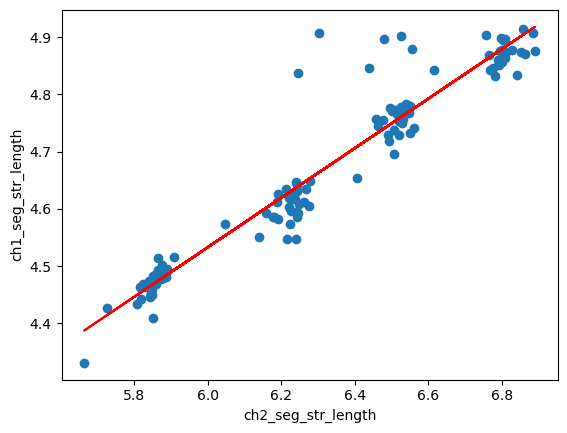

In [73]:
### Now lets do the deviation from normal proportions

column_body = 'ch2_seg_str_length'
column_pharynx = 'ch1_seg_str_length'

column_body_at_ecdysis = [f'{column_body}_at_{ecdysis}' for ecdysis in ['M1', 'M2', 'M3', 'M4']]
column_pharynx_at_ecdysis = [f'{column_pharynx}_at_{ecdysis}' for ecdysis in ['M1', 'M2', 'M3', 'M4']]

reference_condition = 3

df_condition = experiment_filemap[experiment_filemap['condition_id'] == reference_condition]

body_at_ecdysis = []
pharynx_at_ecdysis = []
for point in df_condition['Point'].unique():
    point_df = df_condition[df_condition['Point'] == point]
    body_at_ecdysis.append(point_df[column_body_at_ecdysis].iloc[0].values)
    pharynx_at_ecdysis.append(point_df[column_pharynx_at_ecdysis].iloc[0].values)
    # series_body = point_df[column_body].values
    # series_pharynx = point_df[column_pharynx].values

    # series_body = filter_series_with_classification(series_body, point_df['ch2_seg_str_worm_type'].values)
    # series_pharynx = filter_series_with_classification(series_pharynx, point_df['ch2_seg_str_worm_type'].values)

    # body_at_ecdysis.append(series_body)
    # pharynx_at_ecdysis.append(series_pharynx)

body_at_ecdysis = np.array(body_at_ecdysis).flatten()
pharynx_at_ecdysis = np.array(pharynx_at_ecdysis).flatten()

# remove elements that are nan in one of the two arrays
correct_indices = ~np.isnan(body_at_ecdysis) & ~np.isnan(pharynx_at_ecdysis)
body_at_ecdysis = body_at_ecdysis[correct_indices]
pharynx_at_ecdysis = pharynx_at_ecdysis[correct_indices]

# log transform the data
body_at_ecdysis = np.log(body_at_ecdysis)
pharynx_at_ecdysis = np.log(pharynx_at_ecdysis)

plt.scatter(body_at_ecdysis, pharynx_at_ecdysis)
plt.xlabel(column_body)

fit = np.polyfit(body_at_ecdysis, pharynx_at_ecdysis, 1)
model = np.poly1d(fit)
plt.plot(body_at_ecdysis, model(body_at_ecdysis), color='red')
plt.ylabel(column_pharynx)
plt.show()


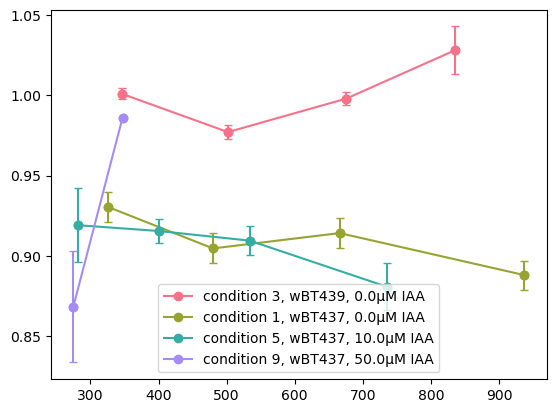

In [81]:
import seaborn as sns
color_palette = sns.color_palette("husl", 4)
# for i, condition in enumerate([0, 4, 8]):
for i, condition in enumerate([3, 1, 5, 9]):
# for i, condition in enumerate(list(range(12))):
    df_condition = experiment_filemap[experiment_filemap['condition_id'] == condition]

    data_x = []
    data_y = []
    data_y_err = []
    for col_body, col_pharynx in zip(column_body_at_ecdysis, column_pharynx_at_ecdysis):
        body_at_ecdys = []
        pharynx_at_ecdys = []
        for point in df_condition['Point'].unique():
            point_df = df_condition[df_condition['Point'] == point]
            body_at_ecdys.append(point_df[col_body].iloc[0])
            pharynx_at_ecdys.append(point_df[col_pharynx].iloc[0])
        
        body_at_ecdys = np.array(body_at_ecdys)
        pharynx_at_ecdys = np.array(pharynx_at_ecdys)

        # remove elements that are nan in one of the two arrays
        correct_indices = ~np.isnan(body_at_ecdys) & ~np.isnan(pharynx_at_ecdys)

        body_at_ecdys = body_at_ecdys[correct_indices]
        pharynx_at_ecdys = pharynx_at_ecdys[correct_indices]

        # log transform the data
        body_at_ecdys = np.log(body_at_ecdys)
        pharynx_at_ecdys = np.log(pharynx_at_ecdys)

        expected_pharynx = model(body_at_ecdys)
        log_residuals = pharynx_at_ecdys - expected_pharynx
        residuals = np.exp(log_residuals)
        
        y = np.mean(residuals)
        y_err = np.std(residuals)/np.sqrt(len(residuals))
        x = np.mean(body_at_ecdys)
        data_x.append(np.exp(x))
        data_y.append(y)
        data_y_err.append(y_err)
    
    plt.plot(data_x, data_y, color=color_palette[i], marker='o', label=f'condition {condition}, {df_condition["strain"].iloc[0]}, {df_condition["auxin_concentration_um"].iloc[0]}µM IAA')
    plt.errorbar(data_x, data_y, yerr=data_y_err, color=color_palette[i], fmt='o', capsize=3)
plt.legend()
plt.show()
        
    